In [38]:
import os
import pandas as pd
import random
random.seed(77)
import matplotlib.pyplot as plt
import glob

In [2]:
# 사용할 변수
# 1. 분류 기준 : 세 가지 질병 + 정상 상태 
symptoms = ["CNV", "DME", "DRUSEN", "NORMAL"]
# 2. 폴더 절대 경로
path_dirs = {"test_dir": "/Users/jh/Desktop/OCT2017/test/",
             "train_dir":  "/Users/jh/Desktop/OCT2017/train/"}
# 3. 이동할 경로 
goal_dir =  "/Users/jh/Desktop/OCT_sampling/train/"

In [3]:
#train 폴더 체크 
train_total = []
for name in symptoms : 
    get_list = os.listdir(goal_dir + name)
    train_total.extend(get_list)
len(train_total)

69864

In [4]:
train_total[:4]

['CNV-163081-153.jpeg',
 'CNV-3537912-28.jpeg',
 'CNV-8087608-23.jpeg',
 'CNV-398897-1.jpeg']

In [5]:
#train 파일 리스트로 데이터프레임 만들기 
classify = []
patient = []
fileno = []

for name in train_total:
    classify.append(name.split("-")[0])
    patient.append(name.split("-")[1])
    fileno.append(name.split("-")[2].split(".")[0])
    
train_df = pd.DataFrame({"class":classify, "id":patient, "numbers":fileno})


train_des = train_df[["class", "id"]].groupby("class").count()
train_des["percentage"] = round(train_des["id"] / len(train_total), 4) *100 
train_des

,id,percentage
class,,
CNV,24861,35.58
DME,10436,14.94
DRUSEN,8252,11.81
NORMAL,26315,37.67


In [6]:
len(train_df), len(train_df["id"].unique())

(69864, 4590)

In [7]:
train_df.head()

,class,id,numbers
0,CNV,163081,153
1,CNV,3537912,28
2,CNV,8087608,23
3,CNV,398897,1
4,CNV,457907,44


([], [])

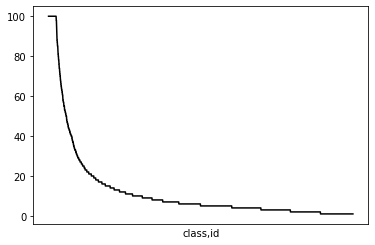

In [8]:
#환자 id 를 기준으로 value_counts -> id당 사진 몇 장인지 확인하기 
#불균형이 엄청 심함 

train_df[["class", "id"]].value_counts().plot(color="black")
plt.xticks(ticks=[])



In [9]:
#max가 813에 달하는 것을 확인할 수 있다 
train_df[["class", "id"]].value_counts().describe()

count    5620.000000
mean       12.431317
std        19.672910
min         1.000000
25%         3.000000
50%         5.000000
75%        12.000000
max       100.000000
dtype: float64

In [10]:
train_df

,class,id,numbers
0,CNV,163081,153
1,CNV,3537912,28
2,CNV,8087608,23
3,CNV,398897,1
4,CNV,457907,44
...,...,...,...
69859,NORMAL,4982430,4
69860,NORMAL,4192922,12
69861,NORMAL,5685882,9
69862,NORMAL,2137983,4


In [11]:
classid = train_df[["class", "id"]].drop_duplicates()
classid

,class,id
0,CNV,163081
1,CNV,3537912
2,CNV,8087608
3,CNV,398897
4,CNV,457907
...,...,...
69130,NORMAL,629493
69200,NORMAL,9317399
69202,NORMAL,5339392
69216,NORMAL,8150554


In [23]:
# normal 클래스도 다른 id와 중복되는 것이 없는지 체크
# 사유 : 시계열 데이터라 병이 없다가 생긴 경우가 있을 수 있어서 

cnvid = list(classid[classid["class"] == "CNV"].id)
dmeid = list(classid[classid["class"] == "DME"].id)
drusenid = list(classid[classid["class"] == "DRUSEN"].id)
normid = list(classid[classid["class"] == "NORMAL"].id)

#CNV증상만 있는 id
onlycnv = set(cnvid) - set(dmeid) - set(drusenid) - set(normid)

#DME증상만 있는 id
onlydme = set(dmeid) - set(cnvid) - set(drusenid) - set(normid)

#DRUSEN증상만 있는 id 
onlydru = set(drusenid) - set(dmeid) - set(cnvid) - set(normid)

#Normal id
onlynorm = set(normid) - set(dmeid) - set(cnvid) - set(drusenid)

#합치기 
pureid = []
pureid.extend(list(onlycnv))
pureid.extend(list(onlydme))
pureid.extend(list(onlydru))
pureid.extend(list(onlynorm))


In [25]:
len(pureid)

3719

In [27]:
classid = classid[classid["id"].isin(pureid)]

In [49]:
trainset = pd.DataFrame()
trainset = pd.concat([classid[classid["class"] == "CNV"].sample(frac=0.7, random_state=77),
                     classid[classid["class"] == "DME"].sample(frac=0.7, random_state=77),
                     classid[classid["class"] == "DRUSEN"].sample(frac=0.7, random_state=77),
                     classid[classid["class"] == "NORMAL"].sample(frac=0.7, random_state=77)], 
                   axis=0)
len(trainset)


2603

In [54]:
remains = list(classid.index[classid.index.isin(trainset.index) == False])
remains = classid.loc[remains]

testset = pd.DataFrame()
testset = pd.concat([remains[remains["class"] == "CNV"].sample(frac=0.67, random_state=77),
                     remains[remains["class"] == "DME"].sample(frac=0.67, random_state=77),
                     remains[remains["class"] == "DRUSEN"].sample(frac=0.67, random_state=77),
                     remains[remains["class"] == "NORMAL"].sample(frac=0.67, random_state=77)], 
                   axis=0)

remains = list(remains.index[remains.index.isin(testset.index) == False])
valset = classid.loc[remains]

In [55]:
len(testset), len(valset)

(748, 368)

In [58]:
print("Ratio of train id", round(len(trainset)/ (len(trainset) + len(testset) + len(valset)), 2))
print("Ratio of test id ", round(len(testset)/ (len(trainset) + len(testset) + len(valset)), 2))
print("Ratio of validation id", round(len(valset)/ (len(trainset) + len(testset) + len(valset)), 2))

Ratio of train id 0.7
Ratio of test id  0.2
Ratio of validation id 0.1


In [59]:
totaltrain = []
for c, i in zip(trainset["class"], trainset["id"]):
    dummydir = "/Users/jh/Desktop/OCT_sampling/train/" + c + "/" + c + "-" + i + "-" + "*"
    output = glob.glob(dummydir)
    totaltrain.extend(output)
    
len(totaltrain)

27525

In [60]:
totaltest = []
for c, i in zip(testset["class"], testset["id"]):
    dummydir = "/Users/jh/Desktop/OCT_sampling/train/" + c + "/" + c + "-" + i + "-" + "*"
    output = glob.glob(dummydir)
    totaltest.extend(output)
    
len(totaltest)

6891

In [61]:
totalval = []
for c, i in zip(valset["class"], valset["id"]):
    dummydir = "/Users/jh/Desktop/OCT_sampling/train/" + c + "/" + c + "-" + i + "-" + "*"
    output = glob.glob(dummydir)
    totalval.extend(output)
    
len(totalval)

3917

In [62]:
print("Ratio of train data", round(len(totaltrain)/ (len(totaltrain) + len(totaltest) + len(totalval)), 2))
print("Ratio of test data", round(len(totaltest)/ (len(totaltrain) + len(totaltest) + len(totalval)), 2))
print("Ratio of validation data", round(len(totalval)/ (len(totaltrain) + len(totaltest) + len(totalval)), 2))

Ratio of train data 0.72
Ratio of test data 0.18
Ratio of validation data 0.1
